In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, MaxPool2D, Input, Dense

import numpy as np

import matplotlib.pyplot as plt

import cv2

import os

from random import sample

In [2]:
class Combine(keras.layers.Layer):
    def __init__(self, *args, **kwargs):
        super(Combine, self).__init__(*args, **kwargs)

    def build(self, input_shape):
        self.alpha = tf.Variable(initial_value=tf.zeros_initializer()(shape=(1,), dtype="float32"), trainable=False)
        
    def get_config(self):
        config = super(Combine, self).get_config().copy()
        return config

    def call(self, inputs):
        return self.alpha*inputs[0] + (1 - self.alpha)*inputs[1]

In [3]:
class ImageGenerator(object):
    def __init__(self, images_folder_path, initial_images_size=4, batch_size=16):
        self.__images_folder_path = images_folder_path
        self.__images_size = initial_images_size
        self.__batch_size = batch_size
        self.__filenames = []

        for _, _, fnames in os.walk(self.__images_folder_path):
            for fname in fnames:
                if fname.split('.')[-1] in ('jpg', 'jpeg'):
                    self.__filenames.append(fname)
            break
    
        print(f'Loaded {len(self.__filenames)} images.')
    
    def set_images_size(self, size):
        self.__images_size = size

    def get_batch(self):
        result = np.zeros((self.__batch_size, self.__images_size, self.__images_size, 3))

        fnames = sample(self.__filenames, self.__batch_size)

        for i in range(self.__batch_size):
            img = cv2.imread(os.path.join(self.__images_folder_path, fnames[i]))[:,:,::-1]
            min_size = min(img.shape[:2])
            img = img[(img.shape[0] - min_size)//2:(img.shape[0] + min_size)//2,
                      (img.shape[1] - min_size)//2:(img.shape[1] + min_size)//2]
            img = cv2.resize(img, (self.__images_size,)*2)
            result[i,] = img.astype(np.float32)/255
        
        return result

In [4]:
def clone_layer(layer):
    config = layer.get_config()
    del config['name']
    weights = layer.get_weights()
    cloned_layer = type(layer).from_config(config)
    cloned_layer.build(layer.input_shape)
    cloned_layer.set_weights(weights)
    return cloned_layer

In [5]:
class ProgressiveGAN(object):
    def __init__(self, latent_dim=128, initial_image_size=4, final_image_size=512):
        self.__latent_dim = latent_dim
        self.__initial_image_size = initial_image_size
        self.__final_image_size= final_image_size

        self.__current_image_size = self.__initial_image_size

        self.__generator = self.__init_generator()
        self.__discriminator = self.__init_discriminator()
        self.__gan = self.__init_gan()
    
    @property
    def generator(self):
        return self.__generator

    @property
    def discriminator(self):
        return self.__discriminator

    @property
    def gan(self):
        return self.__gan

    def fit(self, image_generator, lr=.01):
        pass

    def __init_generator(self):
        generator_input = x = Input((1, 1, self.__latent_dim))

        x = Conv2DTranspose(self.__latent_dim, 4, activation='relu')(x)
        x = Conv2D(self.__latent_dim, 3, padding='same', activation='relu')(x)

        output_size = 4

        while output_size < self.__initial_image_size:
            filters = self.__filters_count(output_size)

            x = UpSampling2D()(x)
            x = Conv2D(filters, 3, padding='same', activation='relu')(x)
            x = Conv2D(filters, 3, padding='same', activation='relu')(x)

            output_size <<= 1

        x = Conv2D(3, 1, padding='same', activation='relu')(x)

        return keras.Model(generator_input, x, name='generator')

    def __init_discriminator(self):
        discriminator_input = x = Input((self.__initial_image_size, self.__initial_image_size, 3))

        x = Conv2D(self.__filters_count(self.__initial_image_size << 1), 1, padding='same', activation='relu')(x)

        output_size = self.__initial_image_size

        while output_size > 4:
            x = Conv2D(self.__filters_count(output_size << 1), 3, padding='same', activation='relu')(x)
            x = Conv2D(self.__filters_count(output_size), 3, padding='same', activation='relu')(x)
            x = MaxPool2D()(x)

            output_size >>= 1

        x = Conv2D(self.__filters_count(output_size), 3, padding='same', activation='relu')(x)
        x = Conv2D(self.__latent_dim, 4, activation='relu')(x)
        x = Dense(1, activation='sigmoid')(x)

        return keras.Model(discriminator_input, x, name='discriminator')
    
    def __init_gan(self):
        gan_input = x = Input((1, 1, self.__latent_dim))

        return keras.Model(gan_input, self.__discriminator(self.__generator(gan_input)), name='gan')
    
    def increase_image_size(self):
        self.__current_image_size <<= 1

        # generator

        # new layers
        x = UpSampling2D()(self.__generator.layers[-2].output)
        x = Conv2D(self.__filters_count(self.__current_image_size), 3, padding='same')(x)
        x = Conv2D(self.__filters_count(self.__current_image_size), 3, padding='same')(x)

        x = Conv2D(3, 1, padding='same')(x)

        # upsample previous output
        prev_step_output = self.__generator.output
        prev_step_rgb = keras.layers.UpSampling2D()(prev_step_output)

        x = Combine(name='generator_combine')([x, prev_step_rgb])

        self.__generator = keras.Model(self.__generator.input, x, name='generator')

        # discriminator
        discriminator_input = Input((self.__current_image_size, self.__current_image_size, 3))

        prev_step_downsample = MaxPool2D()(discriminator_input)

        prev_step_rgb = self.__discriminator.layers[1](prev_step_downsample)

        x = Conv2D(self.__filters_count(self.__current_image_size << 1), 1, padding='same')(x)

        x = Conv2D(self.__filters_count(self.__current_image_size << 1), 3, padding='same')(discriminator_input)
        x = Conv2D(self.__filters_count(self.__current_image_size), 3, padding='same')(x)
        new_step_output = MaxPool2D()(x)

        print(self.__filters_count(self.__current_image_size), new_step_output.name, prev_step_rgb.name)

        x = Combine(name='discriminator_combine')([new_step_output, prev_step_rgb])
        
        for layer in self.__discriminator.layers[2:]:
            x = clone_layer(layer)(x)

        self.__discriminator = keras.Model(discriminator_input, x, name='discriminator')

        # gan
        self.__gan = self.__init_gan()
    
    def drop_combine_layer(self):
        # generator
        layer = self.__generator.layers[0]

        layers = []
        i = -1
        s = self.__initial_image_size
        while s < self.__current_image_size:
            s <<= 1
            i += 1

        while True:
            layer = layer._outbound_nodes[0].layer
            layers.append(layer)
            if len(set(map(lambda x: x.layer.name, layer._outbound_nodes))) != 1:
                break
                # if i == 0:
                #     break
                # i -= 1

        outs = list(set(layer._outbound_nodes))

        layer_a = outs[0].layer
        layer_b = outs[1].layer

        branch_a = [layer_a]
        branch_b = [layer_b]
        
        while len(layer_a._outbound_nodes) > 0:
            layer_a = layer_a._outbound_nodes[0].layer
            branch_a.append(layer_a)
        
        while len(layer_b._outbound_nodes) > 0:
            layer_b = layer_b._outbound_nodes[0].layer
            branch_b.append(layer_b)

        if len(branch_a) > len(branch_b):
            layers.extend(branch_a)
            
        else:
            layers.extend(branch_b)

        generator_input = x = keras.layers.Input(shape=self.__generator.input.shape[1:])
        for layer in layers:
            if 'combine' in layer.name:
                break
            x = clone_layer(layer)(x)

        self.__generator = keras.Model(generator_input, x, name='generator')

        # discirminator
        layer = self.__discriminator.layers[0]

        layer_a = layer._outbound_nodes[0].layer
        layer_b = layer._outbound_nodes[1].layer

        branch_a = [layer_a]
        branch_b = [layer_b]
        
        while len(layer_a._outbound_nodes) > 0:
            layer_a = layer_a._outbound_nodes[0].layer
            branch_a.append(layer_a)
        
        while len(layer_b._outbound_nodes) > 0:
            layer_b = layer_b._outbound_nodes[0].layer
            branch_b.append(layer_b)

        if len(branch_a) > len(branch_b):
            layers = branch_a
            
        else:
            layers = branch_b

        discriminator_input = x = keras.layers.Input(self.__discriminator.input.shape[1:])
        for layer in layers:
            if 'combine' in layer.name:
                continue
            x = clone_layer(layer)(x)

        self.__discriminator = keras.Model(discriminator_input, x, name='discriminator')

        # self.__generator.summary()
        # self.__discriminator.summary()
        
        # gan
        self.__gan = self.__init_gan()

    def __filters_count(self, output_size):
        filters = self.__latent_dim
        while output_size*filters >= self.__final_image_size*16:
            filters //= 2
        
        return filters

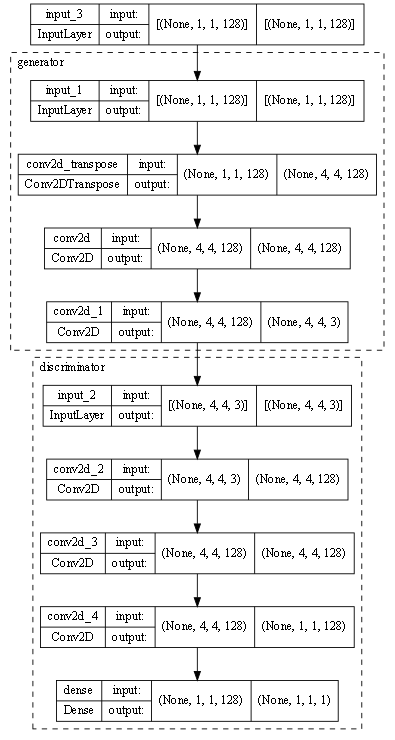

In [6]:
progan = ProgressiveGAN(initial_image_size=4)
keras.utils.plot_model(progan.gan, expand_nested=True, show_shapes=True, dpi=64)

128 max_pooling2d_1/MaxPool:0 conv2d_2/Relu:0


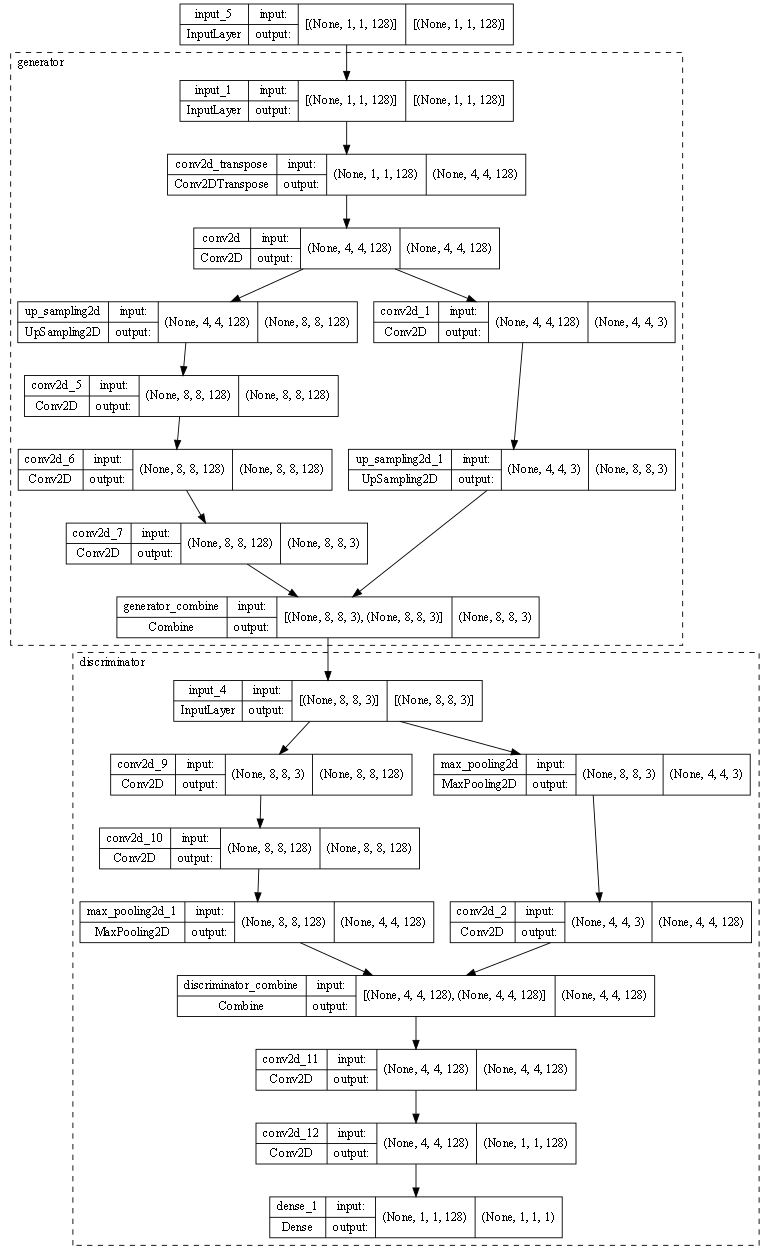

In [7]:
progan.increase_image_size()
keras.utils.plot_model(progan.gan, expand_nested=True, show_shapes=True, dpi=64)

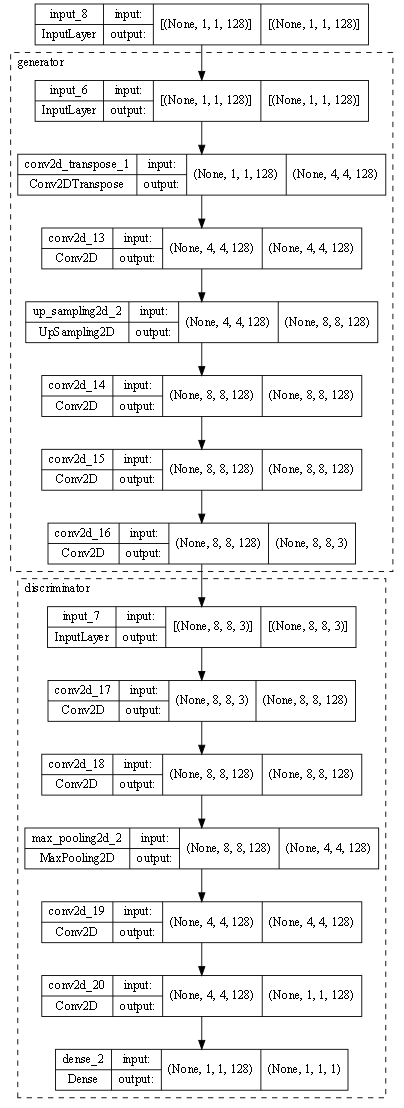

In [8]:
progan.drop_combine_layer()
keras.utils.plot_model(progan.gan, expand_nested=True, show_shapes=True, dpi=64)

In [9]:
img_gen = ImageGenerator(r'E:\Workspace\datasets\cats', batch_size=32)

Loaded 9993 images.


In [10]:
img_gen.set_images_size(128)

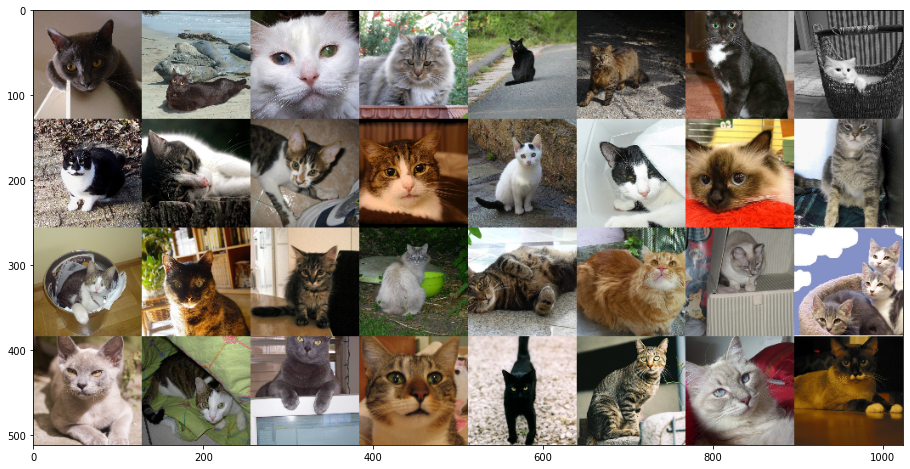

In [11]:
batch = img_gen.get_batch()
plt.figure(figsize=(64, 8))

plt.imshow(np.vstack([np.hstack([batch[8*j + i] for i in range(8)]) for j in range(4)]))

plt.show()

In [12]:
img = cv2.imread(os.path.join(r'E:\Workspace\datasets\cats', '00000001_005.jpg'))

In [13]:
img.resize((64, 64, 3))

In [14]:
img.shape

(64, 64, 3)